# House Prices Advanced Regression Techniques 4

In this part, we will try to find the best setting for CatBoostRegressor

## Baseline

We use model from P3 as baseline. Taking all columns, default parameters, and no feature engineering.

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer, TransformedTargetRegressor

from catboost import CatBoostRegressor

In [18]:
continuous_pip = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

discrete_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder()
)

preprocess_pipe = make_column_transformer(
    (continuous_pip, make_column_selector(dtype_include=np.number)),
    (discrete_pipe, make_column_selector(dtype_include=object))
)

cat_boost_regressor = CatBoostRegressor(random_state=42, silent=True, allow_writing_files=False)
log_level_regressor = TransformedTargetRegressor(
    cat_boost_regressor,
    func=np.log1p,
    inverse_func=np.expm1,
)

cat_boost_pipe_v1 = make_pipeline(
    preprocess_pipe,
    log_level_regressor
)

In [19]:
df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")

df_preprocess = preprocess_pipe.fit_transform(df_train.drop(columns=["Id", "SalePrice"]))
df_target = df_train["SalePrice"]

baseline_score = cross_val_score(cat_boost_regressor, df_preprocess, np.log1p(df_target), cv=5, scoring="neg_root_mean_squared_error")
print(f"Baseline score: {baseline_score.mean():.3f} +/- {baseline_score.std():.3f}")

Baseline score: -0.121 +/- 0.012


## Try with selected features from P1

In [29]:
high_correlated_with_sale_price = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd',
                                   'AgeBuilt', 'AgeRemodAdd']

def fill_missing(df: pd.DataFrame):
    continuous_imputer = SimpleImputer(strategy='median')
    discrete_imputer = SimpleImputer(strategy='most_frequent')

    continuous_columns_ = df.select_dtypes(include=['float64', 'int64']).columns
    discrete_columns_ = df.select_dtypes(include=['object']).columns

    df[continuous_columns_] = continuous_imputer.fit_transform(df[continuous_columns_])
    df[discrete_columns_] = discrete_imputer.fit_transform(df[discrete_columns_])

    df[continuous_columns_] = df[continuous_columns_].astype('float64')
    df[discrete_columns_] = df[discrete_columns_].astype('category')

    return df

def year_to_age(df: pd.DataFrame):
    df['AgeBuilt'] = 2016 - df['YearBuilt']
    df['AgeRemodAdd'] = 2016 - df['YearRemodAdd']
    return df

def normalize(df: pd.DataFrame):
    continuous_columns_ = df.select_dtypes(include=['float64', 'int64']).columns

    scaler = StandardScaler()
    df[continuous_columns_] = scaler.fit_transform(df[continuous_columns_])

    return df

def encode(df: pd.DataFrame):
    discrete_columns_ = df.select_dtypes(include=['object']).columns

    encoder = OrdinalEncoder()
    df[discrete_columns_] = encoder.fit_transform(df[discrete_columns_])

    return df

def select_features(df: pd.DataFrame):
    return df[high_correlated_with_sale_price]

preprocess_pipe_v2 = make_pipeline(
    FunctionTransformer(fill_missing),
    FunctionTransformer(year_to_age),
    FunctionTransformer(select_features),
    FunctionTransformer(normalize),
    FunctionTransformer(encode),
)

df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
df_preprocess_v2 = preprocess_pipe_v2.fit_transform(df_train)
cat_boost_v2_score = cross_val_score(
    cat_boost_regressor,
    df_preprocess_v2,
    np.log1p(df_target),
    cv=5,
    scoring="neg_root_mean_squared_error"
)

print(f"CatBoost score: {cat_boost_v2_score.mean():.3f} +/- {cat_boost_v2_score.std():.3f}")

C:\Users\duongdinh\AppData\Local\Temp\ipykernel_6580\2045314949.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[continuous_columns_] = scaler.fit_transform(df[continuous_columns_])


CatBoost score: -0.156 +/- 0.008


Worse than baseline. We will make prediction anyway.

In [31]:
cat_boost_pipe_v2 = make_pipeline(
    preprocess_pipe_v2,
    log_level_regressor
)

df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
cat_boost_pipe_v2.fit(df_train, df_train["SalePrice"])

C:\Users\duongdinh\AppData\Local\Temp\ipykernel_6580\2045314949.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[continuous_columns_] = scaler.fit_transform(df[continuous_columns_])


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer-1',
                                  FunctionTransformer(func=<function fill_missing at 0x000002112B17F760>)),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=<function year_to_age at 0x000002112B17FBE0>)),
                                 ('functiontransformer-3',
                                  FunctionTransformer(func=<function select_features at 0x000002112B2F7490>)),
                                 ('functiontransformer-4',
                                  FunctionTransformer(func=<function normalize at 0x0000021127BE5480>)),
                                 ('functiontransformer-5',
                                  FunctionTransformer(func=<function encode at 0x000002112B2F7D00>))])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=<catboost.core.CatBoostRegressor object at 0x0000021127AF7370>))])

C:\Users\duongdinh\AppData\Local\Temp\ipykernel_6580\2045314949.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[continuous_columns_] = scaler.fit_transform(df[continuous_columns_])


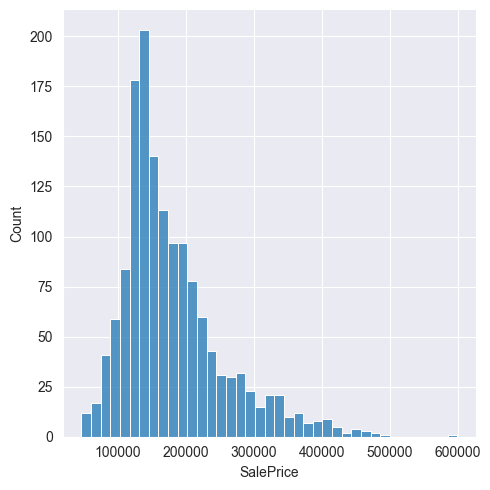

In [33]:
df_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
df_test["SalePrice"] = cat_boost_pipe_v2.predict(df_test)

sns.displot(df_test["SalePrice"])

In [35]:
df_test["Id"] = df_test["Id"].astype(int)
df_test[["Id", "SalePrice"]].to_csv("../input/house-prices-advanced-regression-techniques/submission/cat-boost-v4.csv", index=False)

Score: 0.15207

It did worse

## Find best parameters

This would take very very long time.

In [20]:
# cat_boost_params = {
#     'iterations': [500, 1000, 1500],
#     'learning_rate': [0.01, 0.03, 0.1],
#     'depth': [3, 6, 9],
#     'l2_leaf_reg': [1, 3, 5],
#     'bagging_temperature': [0.5, 1, 2],
# }
#
# cat_boost_grid_search = GridSearchCV(
#     cat_boost_regressor,
#     cat_boost_params,
#     cv=5,
#     scoring="neg_root_mean_squared_error",
#     n_jobs=-1,
#     verbose=1,
# )

# This will take very long long time
# cat_boost_grid_search.fit(df_preprocess, np.log1p(df_target))

# print(f"Best score: {cat_boost_grid_search.best_score_:.3f}")
# print(f"Best params: {cat_boost_grid_search.best_params_}")